In [1]:

import os
import re
import string
from pathlib import Path
from collections import Counter
from html import unescape

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import nltk
from nltk.corpus import stopwords
import emoji
from unidecode import unidecode

# Config
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
sns.set(context="notebook", style="ticks", font_scale=1.0)

OUT_DIR = Path("./figures_cleaned")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# Paleta accesible
PALETTE = {"0": "#3182bd", "1": "#e6550d"}  # 0 = azul, 1 = naranja


In [2]:

try:
    _ = stopwords.words('english')
except LookupError:
    nltk.download('stopwords')
    _ = stopwords.words('english')

stop_words = set(stopwords.words('english'))

CLEAN_CFG = {
    "lower": True,
    "html_unescape": True,
    "strip_accents": True,
    "remove_urls": True,
    "remove_mentions": True,
    "strip_hashtag_symbol": False,
    "split_hashtags": True,
    "remove_emojis": True,
    "remove_punct": True,
    "remove_numbers": False,
    "keep_numbers_set": {"911"},
    "remove_stopwords": True,
    "remove_domain_stopwords": True,
    "domain_stopwords": {"amp", "via", "rt", "gt", "u", "im"},
    "remove_short_tokens": True,
    "short_min_len": 2,
}

URL_RE = re.compile(r'https?://\S+|www\.\S+', re.IGNORECASE)
MENTION_RE = re.compile(r'@\w+')
HASHTAG_RE = re.compile(r'#([A-Za-z0-9_]+)')
PUNCT_RE = re.compile(rf'[{re.escape(string.punctuation)}]')

def split_hashtag_token(tok: str) -> str:
    tok = tok.replace("_", " ")
    parts = re.findall(r"[A-Z]?[a-z]+|[A-Z]+(?=[A-Z]|$)|\d+", tok)
    return " ".join(parts).lower()

def clean_text_pipeline(text: str, cfg=CLEAN_CFG):
    if not isinstance(text, str):
        return "", []
    t = text

    if cfg["html_unescape"]:
        t = unescape(t)
    if cfg["lower"]:
        t = t.lower()
    if cfg["strip_accents"]:
        t = unidecode(t)
    if cfg["remove_urls"]:
        t = URL_RE.sub(" ", t)
    if cfg["remove_mentions"]:
        t = MENTION_RE.sub(" ", t)

    if cfg.get("split_hashtags", False):
        t = re.sub(r"#([A-Za-z0-9_]+)", lambda m: split_hashtag_token(m.group(1)), t)
    elif cfg["strip_hashtag_symbol"]:
        t = HASHTAG_RE.sub(r"\1", t)

    if cfg["remove_emojis"]:
        try:
            t = emoji.replace_emoji(t, replace="")
        except Exception:
            for e in [e["emoji"] for e in emoji.emoji_list(t)]:
                t = t.replace(e, "")

    if cfg["remove_punct"]:
        t = PUNCT_RE.sub(" ", t)

    t = re.sub(r"\s+", " ", t).strip()
    tokens = t.split()

    if cfg["remove_numbers"]:
        tokens = [tok for tok in tokens if not (tok.isdigit() and tok not in cfg["keep_numbers_set"])]

    if cfg["remove_stopwords"]:
        tokens = [tok for tok in tokens if tok not in stop_words]

    if cfg["remove_domain_stopwords"]:
        dom = cfg["domain_stopwords"]
        tokens = [tok for tok in tokens if tok not in dom]

    if cfg["remove_short_tokens"]:
        minlen = cfg["short_min_len"]
        tokens = [tok for tok in tokens if (len(tok) >= minlen or tok in {"a", "i"})]

    return " ".join(tokens), tokens


In [3]:

TRAIN_PATH = Path("./train.csv")
TEST_PATH = Path("./test.csv")

train = pd.read_csv(TRAIN_PATH)
if TEST_PATH.exists():
    test = pd.read_csv(TEST_PATH)
else:
    test = None

# Estadísticas iniciales
print("train shape:", train.shape)
print("Nulos por columna (train):")
print(train.isna().sum())

# Aplica pipeline
train[["text_clean_v2", "tokens_v2"]] = train["text"].apply(lambda s: pd.Series(clean_text_pipeline(s)))
if test is not None:
    test[["text_clean_v2", "tokens_v2"]] = test["text"].apply(lambda s: pd.Series(clean_text_pipeline(s)))

# Longitudes
train["text_char_len"] = train["text"].astype(str).map(len)
train["text_word_len"] = train["text_clean_v2"].map(lambda s: len(s.split()))
print("Resumen longitudes por clase:")
print(train.groupby("target")[["text_char_len", "text_word_len"]].agg(["count","mean","median"]).round(2))


train shape: (7613, 5)
Nulos por columna (train):
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64
Resumen longitudes por clase:
       text_char_len                text_word_len             
               count    mean median         count  mean median
target                                                        
0               4342   95.71  101.0          4342  8.28    8.0
1               3271  108.11  115.0          3271  9.55    9.0


/tmp/ipykernel_23598/2921531401.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=vc.index.astype(str), y=vc.values, palette=[PALETTE[str(i)] for i in vc.index])


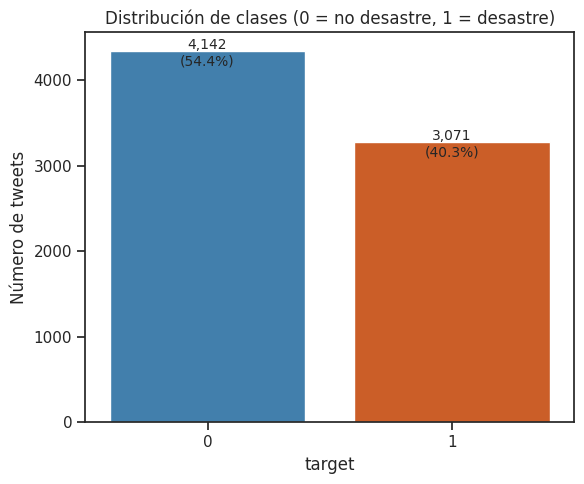

In [4]:
# Distribución de clases
plt.figure(figsize=(6,5))
vc = train["target"].value_counts().sort_index()
ax = sns.barplot(x=vc.index.astype(str), y=vc.values, palette=[PALETTE[str(i)] for i in vc.index])
ax.set_title("Distribución de clases (0 = no desastre, 1 = desastre)")
ax.set_xlabel("target")
ax.set_ylabel("Número de tweets")

# Anotar porcentaje encima de cada barra
total = vc.sum()
for p in ax.patches:
    height = p.get_height()-200
    pct = height / total * 100
    ax.annotate(f"{int(height):,}\n({pct:.1f}%)", (p.get_x() + p.get_width() / 2, height),
                ha="center", va="bottom", fontsize=10)

plt.tight_layout()
plt.savefig(OUT_DIR / "01_class_distribution_pct.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()


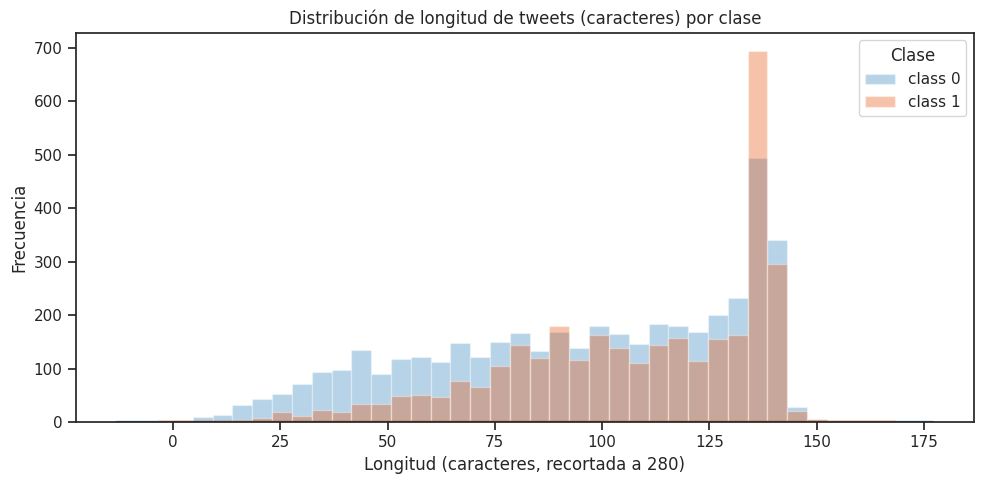

In [5]:
# Grafica 5 - Longitud de tweets: hist + KDE por clase
plt.figure(figsize=(10,5))
max_len = int(min(280, train["text_char_len"].max()))
bins = np.linspace(0, max_len, 35)

# Histograma apilado (semi-transparente) y KDEs
for cls in sorted(train["target"].unique()):
    subset = train.loc[train["target"] == cls, "text_char_len"]
    plt.hist(subset.clip(upper=max_len), bins=bins, alpha=0.35, density=False,
             label=f"class {cls}", color=PALETTE[str(cls)])
    sns.kdeplot(subset.clip(upper=max_len), bw_adjust=1.0, fill=False, color=PALETTE[str(cls)], linewidth=2)

plt.title("Distribución de longitud de tweets (caracteres) por clase")
plt.xlabel("Longitud (caracteres, recortada a 280)")
plt.ylabel("Frecuencia")
plt.legend(title="Clase")
plt.tight_layout()
plt.savefig(OUT_DIR / "02_tweet_length_by_class.png", dpi=200, bbox_inches="tight")
plt.show()
plt.close()


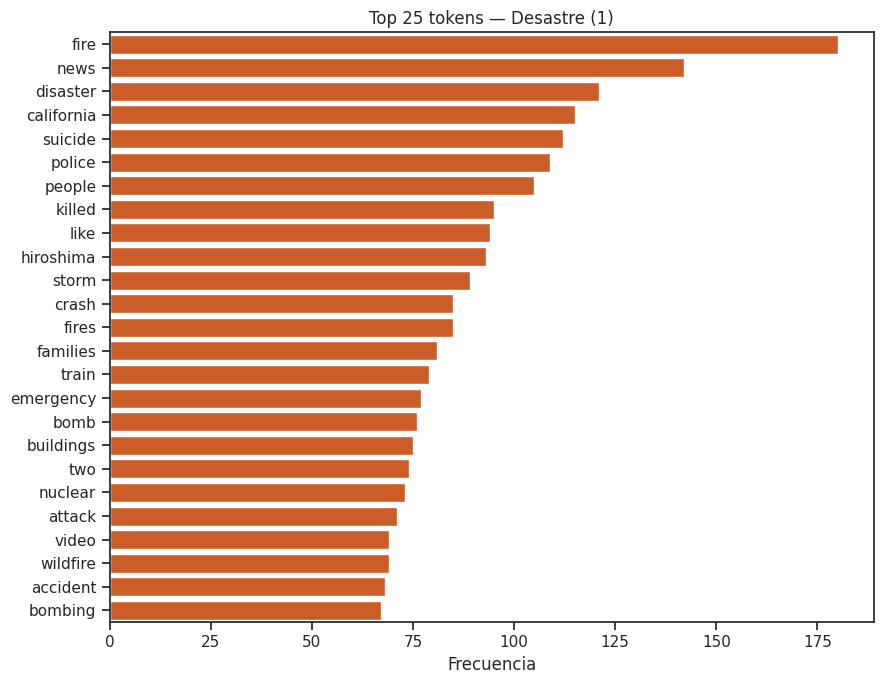

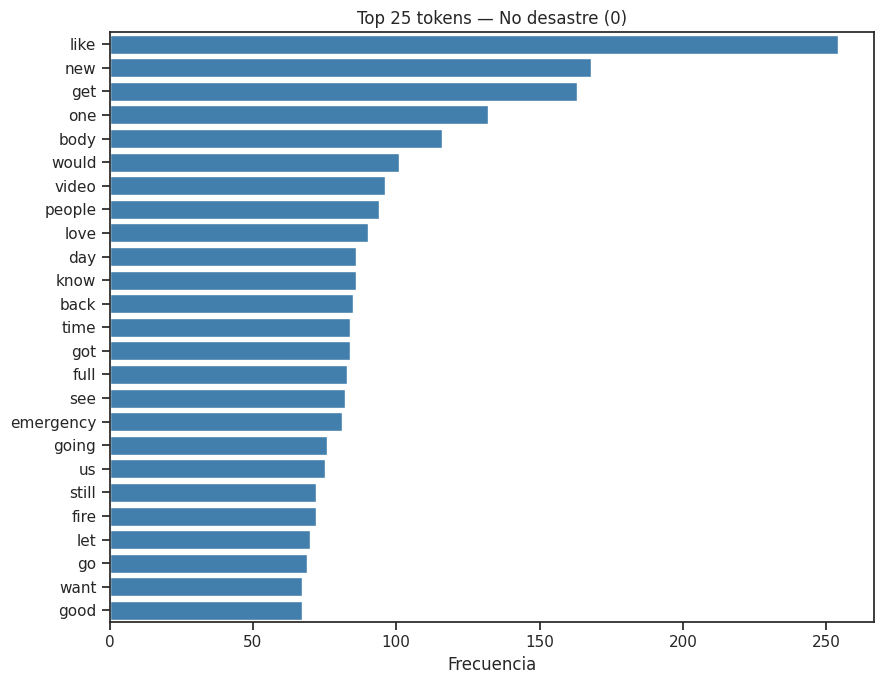

In [6]:
# Grafica 6 - Top unigrams por clase (usando tokens_v2)
def top_tokens_by_class(df, cls, topn=20):
    c = Counter()
    for toks in df.loc[df["target"]==cls, "tokens_v2"]:
        if isinstance(toks, list):
            c.update(toks)
    return c.most_common(topn)

top0 = top_tokens_by_class(train, 0, topn=25)
top1 = top_tokens_by_class(train, 1, topn=25)

def plot_top_tokens(pairs, title, outname, color):
    tokens = [p for p,_ in pairs]
    freqs = [f for _,f in pairs]
    dfp = pd.DataFrame({"token": tokens, "freq": freqs})
    plt.figure(figsize=(9,7))
    sns.barplot(data=dfp, x="freq", y="token", color=color)
    plt.title(title)
    plt.xlabel("Frecuencia")
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(OUT_DIR / outname, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()

plot_top_tokens(top1, "Top 25 tokens — Desastre (1)", "03_top_unigrams_desastre.png", PALETTE["1"])
plot_top_tokens(top0, "Top 25 tokens — No desastre (0)", "04_top_unigrams_nodesastre.png", PALETTE["0"])

# Guardar CSVs para inspección
pd.DataFrame(top1, columns=["token","freq"]).to_csv(OUT_DIR / "top_unigrams_desastre.csv", index=False)
pd.DataFrame(top0, columns=["token","freq"]).to_csv(OUT_DIR / "top_unigrams_nodesastre.csv", index=False)
